In [16]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import os
from torchvision import transforms
import torchvision
import torch.optim as optim
import numpy as np
from sklearn.neighbors import NearestNeighbors
!pip install pytorch_metric_learning
import PIL
import torch.nn.functional as F
from torchsummary import summary

In [2]:
##download dataset 
##밑에 코드 주석을 풀면 cub.zip 파일이 다운받아지고 cub라는 폴더가 생깁니다. 
# !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1o0grxoqCxcrgI6Nd4nxybXulU5IrE8wX' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1o0grxoqCxcrgI6Nd4nxybXulU5IrE8wX" -O CUB.zip && rm -rf /tmp/cookies.txt
# !unzip CUB.zip 
# ! mkdir CUB
# ! mv train ./CUB

In [17]:
class CUBirds(Dataset):
    def __init__(self, root, mode, transform = None): #root: "./"
        
        self.root = os.path.join(root, "CUB/train")
        self.mode = mode
        self.transform = transform
        
        if self.mode == 'train':
            self.classes = range(0,100)
        elif self.mode == 'eval':
            self.classes = range(100,200)

        self.ys, self.im_paths = [], []
        
        image_folder = torchvision.datasets.ImageFolder(root = self.root) ##imagefolder는 계층적인 폴더 구조를 가지고 있는 데이터셋에 사용할 수 있다. 
        
        for i in image_folder.imgs: 
            # i[0]: image path, i[1]: label
            y = i[1]
            if y in self.classes:
                self.ys += [y]
                self.im_paths.append(i[0])
    
    def __getitem__(self, index):
        
        im = PIL.Image.open(self.im_paths[index]).convert('RGB')
        im = self.transform(im)

        target = self.ys[index]

        return im, target
    
    def __len__(self):
        return len(self.ys)

In [18]:
transform = torchvision.transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
        transforms.Resize((224, 224))
    ])

##define dataset
train_dataset = CUBirds("./", mode = "train", transform = transform)
val_dataset = CUBirds("./", mode = "eval", transform = transform)
print(len(train_dataset))
print(len(val_dataset))

full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
print(len(full_dataset))

# define loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=64)

5866
5924
11790


In [22]:
len(full_dataset)

11790

In [5]:
class Resnet18(nn.Module):
    def __init__(self, embedding_size, pretrained=True):
        super(Resnet18, self).__init__()

        self.model = torchvision.models.resnet18(pretrained = pretrained)
        self.embedding_size = embedding_size
        in_features = self.model.fc.in_features
        
        self.model.embedding = nn.Linear(in_features, self.embedding_size)
        

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)

        x = x.view(x.size(0), -1)
        x = self.model.embedding(x) ## embedding the vector to embedding space

        return x

In [6]:
#define model
device = "cuda:0"
model = Resnet18(512, True)
summary(model, batch_size=-1, input_size=(3, 224, 224), device='cpu')
model = model.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [7]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0, num_classes = 200):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.num_classes = num_classes

    def forward(self, output, labels): ##output shape: [batch, embedding_size], labels shape: [Batch,]
        ##compute label matrix
        labels = labels.detach().cpu().numpy()
        num_samples = labels.shape[0]
        mask_multi, target = np.zeros([self.num_classes, num_samples]), 1.0  ##200, 64

        for c in range(self.num_classes):
            c_indices = np.where(labels==c)
            mask_multi[c, c_indices] = target
            
        index_matrix = torch.tensor(mask_multi).to("cuda")
        label = index_matrix[labels] # 64 * 64 
        
        ##compute pairwise euclidean distance
        euclidean_distance = torch.cdist(output, output, p = 2)

        ##define loss equation
        loss_contrastive = torch.mean(label * euclidean_distance + (1-label) * torch.clamp(self.margin - euclidean_distance, min = 0.0))

        return loss_contrastive

In [8]:
class ContrastiveLoss_easy(torch.nn.Module):
    def __init__(self, margin=2.0, num_classes = 200):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.num_classes = num_classes

    def forward(self, output, labels): ##output shape: [batch, embedding_size], labels shape: [Batch,]
        ##compute label matrix
        label_y = []
        for i in labels:
            ys = []
            for j in labels:
                if i == j:  ## 같으면 레이블 1
                    ys.append(1)
                else:  ## 다르면 레이블 0
                    ys.append(0)
            label_y.append(ys)
        
        label_y = torch.tensor(label_y).cuda() ##텐서로 바꿔주고 지피유로 올려줌
        
        ##compute pairwise euclidean distance
        euclidean_distance = torch.cdist(output, output, p = 2)
        
        ##define loss equation
        loss_contrastive = torch.mean(label_y * euclidean_distance + (1-label_y) * torch.clamp(self.margin - euclidean_distance, min = 0.0))
        
        return loss_contrastive

In [9]:
##metric learning losses are defined in pytorch_metric_learning package
## many losses are defined in pytorch_metric_learning! try to use other lossses 
# https://github.com/KevinMusgrave/pytorch-metric-learning/tree/master/src/pytorch_metric_learning/losses
# criterion = losses.ContrastiveLoss(neg_margin = 0.5) ##contrastive loss from pytorch github

from pytorch_metric_learning import miners, losses

#define optimizer, criterion
optimizer = optim.Adam(model.parameters(), lr=1e-5) 
criterion = ContrastiveLoss(margin = 2.0, num_classes = 200)  ## custom constrastive loss

In [10]:
EPOCHS = 5

# Training Loop
for epoch in (range(EPOCHS)):
    running_loss = 0.
    model.train()
    for batch_idx, batch in enumerate(train_loader):
        data, target = batch
        data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output,  target.squeeze())
        running_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    train_loss = running_loss/len(train_loader)
    
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    
    ##validation
    valid_loss = 0.
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            data, target = batch
            data, target = data.cuda(), target.cuda()
            
            output = model(data)
        
            loss = criterion(output, target.squeeze())
            valid_loss += loss.item()
            
    val_loss = valid_loss/len(val_loader)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

Epochs = 0, Training Loss : 0.10483451229850839
Epochs = 0, Validation Loss : 6.459645132829032
Epochs = 1, Training Loss : 0.08667125747193663


KeyboardInterrupt: 

In [11]:
## 전체 dataset에 대한 feature vector (embedding)을 구함
def create_embedding(model, full_loader, device):
    model.eval()
    
    # Just a place holder for our 0th image embedding.
    embeddings = torch.tensor([])
    
    with torch.no_grad():
        for batch_idx, data in enumerate(full_loader):
            
            train_img, lbl = data
            train_img = train_img.to(device)
            
            # Get encoder outputs and move outputs to cpu
            enc_output = model(train_img).cpu()
            # Keep adding these outputs to embeddings.
            embeddings = torch.cat((embeddings, enc_output), 0)

    # Return the embeddings
    return embeddings

In [12]:
## image와 가장 비슷한 top k개 image의 idx를 뽑음
def compute_similar_images(image, num_images, embedding, device):
    transform = torchvision.transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), 
        transforms.Resize((224, 224))
    ])
    
    image_tensor = transform(image).to(device)
    image_tensor = image_tensor.unsqueeze(0) # batch dim 늘려줌

    with torch.no_grad():
        image_embedding = model(image_tensor).cpu().detach().numpy() # [1, 512]
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1)) # [1, 512]

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding.reshape((embedding.shape[0], -1)))
    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list

In [13]:
#get embedding of images from full_loader
embedding = create_embedding(model, full_loader, device)

In [14]:
embedding.shape

torch.Size([11788, 512])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[2698, 2679, 2681, 2654, 2649, 2697, 2694, 604, 9731, 2661, 9455, 2650, 2678, 2666, 3178, 9437, 2652, 2691, 11738, 2660]]


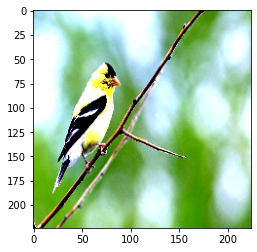

> <ipython-input-15-f80d2ff02538>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


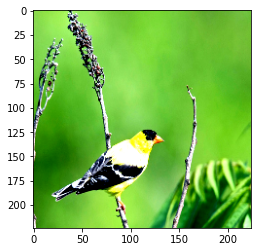

> <ipython-input-15-f80d2ff02538>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


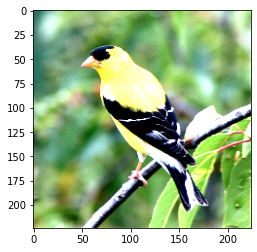

> <ipython-input-15-f80d2ff02538>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  c


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


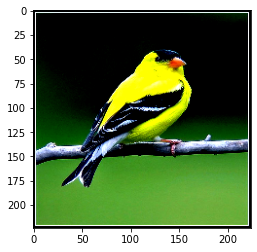

> <ipython-input-15-f80d2ff02538>(15)<module>()
     13 print(indices_list)
     14 
---> 15 for i in indices_list[0]:
     16     img, _ = full_dataset[i]
     17     imshow(img)



ipdb>  q


BdbQuit: 

In [15]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
import matplotlib.pyplot as plt
import PIL

##find the most closest image to input_image in the full_dataset
input_image = PIL.Image.open("bird1.png").convert("RGB")
indices_list = compute_similar_images(input_image, 20, embedding, device)
print(indices_list)

for i in indices_list[0]:
    img, _ = full_dataset[i]
    imshow(img)
    import pdb; pdb.set_trace()